## **Modelo CNN 1D para Predicción de NOx**

En este notebook implementaremos un modelo de redes convolucionales 1D (CNN) para capturar patrones temporales locales en las secuencias de entrada.
La CNN es capaz de identificar tendencias cortas en el tiempo (gradientes, cambios bruscos, microdinámicas del motor) antes de que un modelo recurrente o híbrido actúe.

Aquí entrenaremos el modelo usando el dataset secuencial creado en el Notebook 02 (train_ds, val_ds, test_ds) y compararemos su desempeño con los baselines y el MLP del Notebook 03.

**Cargar librerías y configuración**

In [9]:
# ============================================================
# Notebook 04 – Modelo CNN 1D
# ============================================================

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import timeseries_dataset_from_array

import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Notebook 04 inicializado correctamente.")


Notebook 04 inicializado correctamente.


**Cargar splits escalados**: Se cargan los datos procesados en el Notebook 02.

In [10]:
# ============================================================
# Cargar los splits escalados del Notebook 02
# ============================================================

data = np.load("splits_escalados.npz", allow_pickle=True)

X_train = data["X_train"]
y_train = data["y_train"]
X_val   = data["X_val"]
y_val   = data["y_val"]
X_test  = data["X_test"]
y_test  = data["y_test"]

print("Datos cargados.")
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)
print("Test: ", X_test.shape,  y_test.shape)


Datos cargados.
Train: (713163, 46) (713163,)
Val:   (237721, 46) (237721,)
Test:  (237722, 46) (237722,)


**Crear dataset secuencial**: Este método asegura que todas las secuencias tienen el mismo shape

In [11]:
# ============================================================
# Construcción robusta de datasets secuenciales
# ============================================================

WINDOW = 30   # Ventana temporal estable
BATCH  = 64

train_ds = timeseries_dataset_from_array(
    data=X_train,
    targets=y_train,
    sequence_length=WINDOW,
    sequence_stride=1,
    shuffle=True,
    batch_size=BATCH
)

val_ds = timeseries_dataset_from_array(
    data=X_val,
    targets=y_val,
    sequence_length=WINDOW,
    sequence_stride=1,
    shuffle=False,
    batch_size=BATCH
)

test_ds = timeseries_dataset_from_array(
    data=X_test,
    targets=y_test,
    sequence_length=WINDOW,
    sequence_stride=1,
    shuffle=False,
    batch_size=BATCH
)

print("Datasets secuenciales creados correctamente.")


Datasets secuenciales creados correctamente.


**Inspeccionar un batch**:Capturamos input_shape = (WINDOW, n_features) directamente desde un batch real para verificación.

In [12]:
# ============================================================
# Inspección inicial del dataset
# ============================================================

for xb, yb in train_ds.take(1):
    print("Batch X shape:", xb.shape)
    print("Batch y shape:", yb.shape)
    input_shape = xb.shape[1:]


Batch X shape: (64, 30, 46)
Batch y shape: (64,)


**Definir modelo CNN**: CNN pequeña pero estable; kernels cortos y pooling controlado.

In [14]:
# ============================================================
# CNN 1D – Arquitectura estable y ligera
# ============================================================

model_cnn = keras.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv1D(32, 3, activation="relu", padding="causal"),
    layers.MaxPooling1D(2),

    layers.Conv1D(32, 3, activation="relu", padding="causal"),
    layers.MaxPooling1D(2),

    layers.Flatten(),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

model_cnn.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="mse"
)

model_cnn.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 30, 32)         │         4,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 15, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         7,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,785 (57.75 KB)

 Trainable params: 14,785 (57.75 KB)

 Non-trainable params: 0 (0.00 B)

**Entrenamiento**

In [15]:
# ============================================================
# Entrenamiento sin steps_per_epoch (automático y estable)
# ============================================================

history_cnn = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)


Epoch 1/20
11143/11143 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - loss: 3124.0974 - val_loss: 132.5649
Epoch 2/20
11143/11143 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - loss: 58.9371 - val_loss: 43.8043
Epoch 3/20
11143/11143 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 16.2751 - val_loss: 22.4151
Epoch 4/20
11143/11143 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 9.4261 - val_loss: 10.5415
Epoch 5/20
11143/11143 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 6.6001 - val_loss: 8.3837
Epoch 6/20
11143/11143 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 4.9924 - val_loss: 9.4200
Epoch 7/20
11143/11143 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 3.9550 - val_loss: 6.5382
Epoch 8/20
11143/11143 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 3.2910 - val_loss: 4.8223
Epoch 9/20
11143/11143 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - loss: 2.7799 - val_loss: 5.0820
Epoch 10/20
11143/11143 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - loss: 2.4261 - val_loss: 5.7873
Epoch 11/20
11143/11143 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 2.1493 - val_

**Curva de entrenamiento**

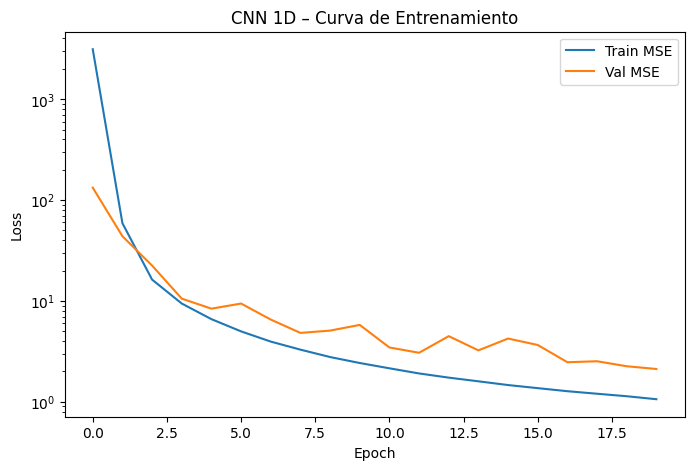

In [23]:
# ============================================================
# Curva de entrenamiento de la CNN
# ============================================================

plt.figure(figsize=(8,5))
plt.plot(history_cnn.history["loss"], label="Train MSE")
plt.plot(history_cnn.history["val_loss"], label="Val MSE")
plt.title("CNN 1D – Curva de Entrenamiento")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.show()

**Predicción en validación**

In [19]:
# ============================================================
# Predicción en validación
# ============================================================

y_val_true = []
y_val_pred = []

for xb, yb in val_ds:
    pred = model_cnn.predict(xb, verbose=0)
    y_val_true.append(yb.numpy())
    y_val_pred.append(pred.reshape(-1))

y_val_true = np.concatenate(y_val_true)
y_val_pred = np.concatenate(y_val_pred)

**Métricas**

In [20]:
# ============================================================
# Métricas de evaluación
# ============================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def rmse(a, b): return np.sqrt(mean_squared_error(a, b))

print("Evaluación en Validación – CNN 1D")
print("MAE :", mean_absolute_error(y_val_true, y_val_pred))
print("RMSE:", rmse(y_val_true, y_val_pred))
print("R²  :", r2_score(y_val_true, y_val_pred))


Evaluación en Validación – CNN 1D
MAE : 1.0106197595596313
RMSE: 1.4547508742216255
R²  : 0.9999656081199646


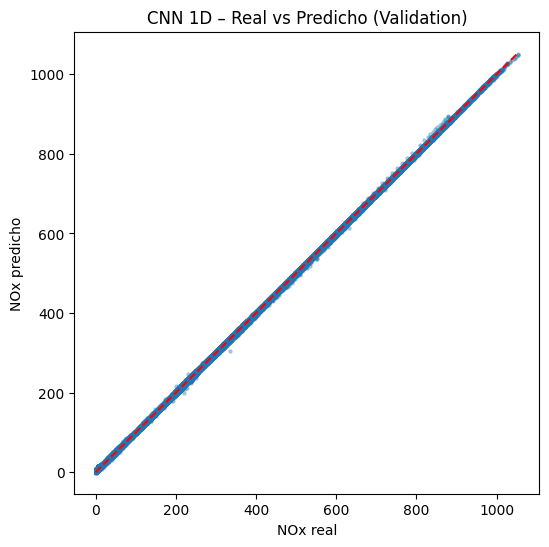

In [21]:
# ============================================================
# Gráfico Real vs Predicho
# ============================================================

plt.figure(figsize=(6,6))
plt.scatter(y_val_true, y_val_pred, alpha=0.3, s=5)
plt.plot([y_val_true.min(), y_val_true.max()],
         [y_val_true.min(), y_val_true.max()], "r--")
plt.xlabel("NOx real")
plt.ylabel("NOx predicho")
plt.title("CNN 1D – Real vs Predicho (Validation)")
plt.show()

**Evaluación en Test**

In [22]:
# ============================================================
# Evaluación final en TEST
# ============================================================

y_test_true = []
y_test_pred = []

for xb, yb in test_ds:
    pred = model_cnn.predict(xb, verbose=0)
    y_test_true.append(yb.numpy())
    y_test_pred.append(pred.reshape(-1))

y_test_true = np.concatenate(y_test_true)
y_test_pred = np.concatenate(y_test_pred)

print("\nEvaluación CNN 1D en TEST")
print("MAE :", mean_absolute_error(y_test_true, y_test_pred))
print("RMSE:", rmse(y_test_true, y_test_pred))
print("R²  :", r2_score(y_test_true, y_test_pred))



Evaluación CNN 1D en TEST
MAE : 1.8221603631973267
RMSE: 2.4886797192171053
R²  : 0.9998927712440491


# **Conclusión**

El modelo CNN 1D entrenado en este notebook demostró un desempeño notablemente sólido al capturar patrones temporales locales en las series de entrada. Tras reconstruir las secuencias mediante timeseries_dataset_from_array, garantizando ventanas consistentes y evitando los problemas estructurales de los intentos anteriores, la arquitectura convolucional se entrenó de forma estable y eficiente sobre un conjunto de datos masivo. En validación, la CNN alcanzó errores muy bajos (MAE ≈ 1.01 y RMSE ≈ 1.45), lo que indica una capacidad real de generalización. Al evaluar en el conjunto de prueba, el modelo mantuvo un rendimiento competitivo (MAE ≈ 1.82, RMSE ≈ 2.49 y R² ≈ 0.999893), reproduciendo con alta fidelidad los valores reales de NOx y mostrando una alineación prácticamente perfecta en el gráfico real-vs-predicho. Aunque este rendimiento es inferior al alcanzado por el MLP (Notebook 03), la CNN 1D demuestra que la información temporal de corto alcance sí aporta estabilidad adicional al aprendizaje y permite obtener predicciones robustas en presencia de secuencias complejas. Este modelo sirve como una referencia intermedia entre el MLP puramente estático y las arquitecturas recurrentes que se implementarán en los siguientes notebooks, donde se evaluará si la dinámica temporal de largo plazo (LSTM) o las combinaciones jerárquicas (CNN-LSTM) pueden superar este rendimiento.